### 

# **Step 0 : Importing Necessasry Libraries**

In [3]:
import os
import numpy as np
import pickle
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Input, add, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt
import re

2024-05-20 09:09:22.975040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 09:09:22.975136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 09:09:23.078902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# **Step 1: Data Preparation**

In [63]:
# Load the Flickr8k dataset images from input files
def load_images(model):
    # extract features from image
    features = {}
    directory = os.path.join(BASE_DIR, 'Images')
    for img_name in tqdm(os.listdir(directory)):
        # load the image from file
        img_path = directory + '/' + img_name
        image = load_img(img_path, target_size=(224, 224))
        # convert image pixels to numpy array
        image = img_to_array(image)
        # reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        # extract features
        feature = model.predict(image, verbose=0)
        # get image ID
        image_id = img_name.split('.')[0]
        # store feature
        features[image_id] = feature
    return features   
    

In [6]:
# Load image caption from files
def load_captions():
    with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
        next(f)
        captions_doc = f.read()
        img_caption = {}
        for line in (captions_doc.split('\n')):
            # Split the line by comma(,)
            tokens = line.split(',')
            if len(tokens) < 2:
                continue
            image_id, caption = tokens[0], tokens[1:]
            # Remove .jpg
            image_id = image_id.split('.')[0]
            # Convert caption list to string
            caption = " ".join(caption)
            if image_id not in img_caption:
                img_caption[image_id] = caption
    return img_caption


In [7]:
# Preprocess captions
def clean(img_caption):
    for img_id, caption in img_caption.items():
        # convert to lowercase
        caption = caption.lower()
        # delete digits, special chars, etc., 
        caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
        caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
        img_caption[img_id] = caption

In [8]:
# Helper function to return a list of all available captions
def collect_all_captions(img_caption):
    all_captions = []
    for img_id in img_caption:
        all_captions.append(img_caption[img_id])
    return all_captions

In [9]:
# Captions tokenizer
def tokenize(all_captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    vocab_size = len(tokenizer.word_index) + 1 # Add 1 for recognizing the padding
    max_length = max(len(caption.split()) for caption in all_captions)
    return tokenizer, vocab_size, max_length

In [10]:
# Data splitter function
def split_data(img_feature):
    image_ids = list(img_feature.keys())
    train_ids = image_ids[:6000]
    validation_ids = image_ids[6000:7000]
    test_ids = image_ids[7000:8000]
    return train_ids, validation_ids, test_ids

In [11]:
def features_and_outputs_labels(img_caption, img_feature, tokenizer, max_length, vocab_size):
    features, sub_sequence, y = list(), list(), list()
    for img_id in img_caption:
        caption = img_caption[img_id]
        # Encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # Split the sequence
        for i in range(1, len(seq)):
            # Split into input and output pairs
            in_seq, out_seq = seq[:i], seq[i]
            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # Encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            # Store the sequences
            features.append(img_feature[img_id][0])
            sub_sequence.append(in_seq)
            y.append(out_seq)
    return np.array(features), np.array(sub_sequence), np.array(y)

# **Step 2: ResNet CNN**

In [12]:
# Function for generating the cnn that we will use for feature extraction
def generate_resNet_model():
    # Define the desired input shape
    input_shape = (224, 224, 3)
    # Load the pre-trained ResNet50 model with ImageNet weights, excluding the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    # Define input layer of the desired shape
    image_input = Input(shape=input_shape)
    x = base_model(image_input)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = Model(inputs=image_input, outputs=x)
    print(model.summary())
    return model

In [13]:
# Helper function for storing features in a pickle file
def store_in_pickle(img_feature):
    pickle.dump(img_feature, open(os.path.join(WORKING_DIR, 'img_feature.pkl'), 'wb'))

In [14]:
def load_from_pickle(img_feature):
    with open(os.path.join(WORKING_DIR, 'img_feature.pkl'), 'rb') as f:
        features = pickle.load(f)

# **Step 3: Recurrent Neural Network (LSTM)**

In [56]:
# Function for bulding out model that we will use for caption prediction
def generate_model(max_length, vocab_size, embedding_vector_size, dropout):
    # Encoder model
    # Image feature layers
    input_1 = Input(shape=(2048,), name="image")
    input_1_2 = Dense(1024, activation='relu')(input_1)
    image_drop_out_layer = Dropout(dropout)(input_1_2)
    input_1_3 = Dense(512, activation='relu')(image_drop_out_layer)
    image_layers_result = Dense(embedding_vector_size, activation='relu')(input_1_3)

    # Sequence feature layers
    input_2 = Input(shape=(max_length,), name="text")
    emb = Embedding(vocab_size, embedding_vector_size, mask_zero=False)(input_2)
    seq_drop_out_layer = Dropout(dropout)(emb)
    lstm_result = LSTM(embedding_vector_size, use_cudnn=False)(seq_drop_out_layer)

    # Decoder model
    decoder1 = add([image_layers_result, lstm_result])
    outputs = Dense(vocab_size, activation='softmax')(decoder1)

    model = Model(inputs=[input_1, input_2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# **Step 4: Model Training**

In [53]:
def train_model(model, img_caption, img_feature, tokenizer, max_length, vocab_size, num_of_epochs):
     # create data generator
    data = features_and_outputs_labels(img_caption, img_feature, tokenizer, max_length, vocab_size)
    model.fit(data, epochs = num_of_epochs, verbose = 1)
    return model

In [17]:
# Helper function for finding the index of a given word in the vocabulary
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [18]:
# Caption prediction function
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        one_hot = model.predict([image, sequence], verbose=0)
        # get index with high probability
        index = np.argmax(one_hot)
        # convert index to word
        word = idx_to_word(index, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

# Driver Code

In [19]:
model = generate_resNet_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [20]:
img_feature = load_images(model)

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1716196183.261356     183 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [21]:
store_in_pickle(img_feature)

In [22]:
load_from_pickle(img_feature)

In [23]:
img_caption = load_captions()

In [24]:
# before preprocess of text
img_caption['1000268201_693b08cb0e']

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [25]:
clean(img_caption)

In [26]:
# after preprocess of text
img_caption['1000268201_693b08cb0e']

'startseq child in pink dress is climbing up set of stairs in an entry way endseq'

In [27]:
all_captions = collect_all_captions(img_caption)

In [28]:
tokenizer, vocab_size, max_length = tokenize(all_captions)

In [29]:
train_ids, validation_ids, test_ids = split_data(img_feature)

In [30]:
model = generate_model(max_length, vocab_size, 256, 0.2)

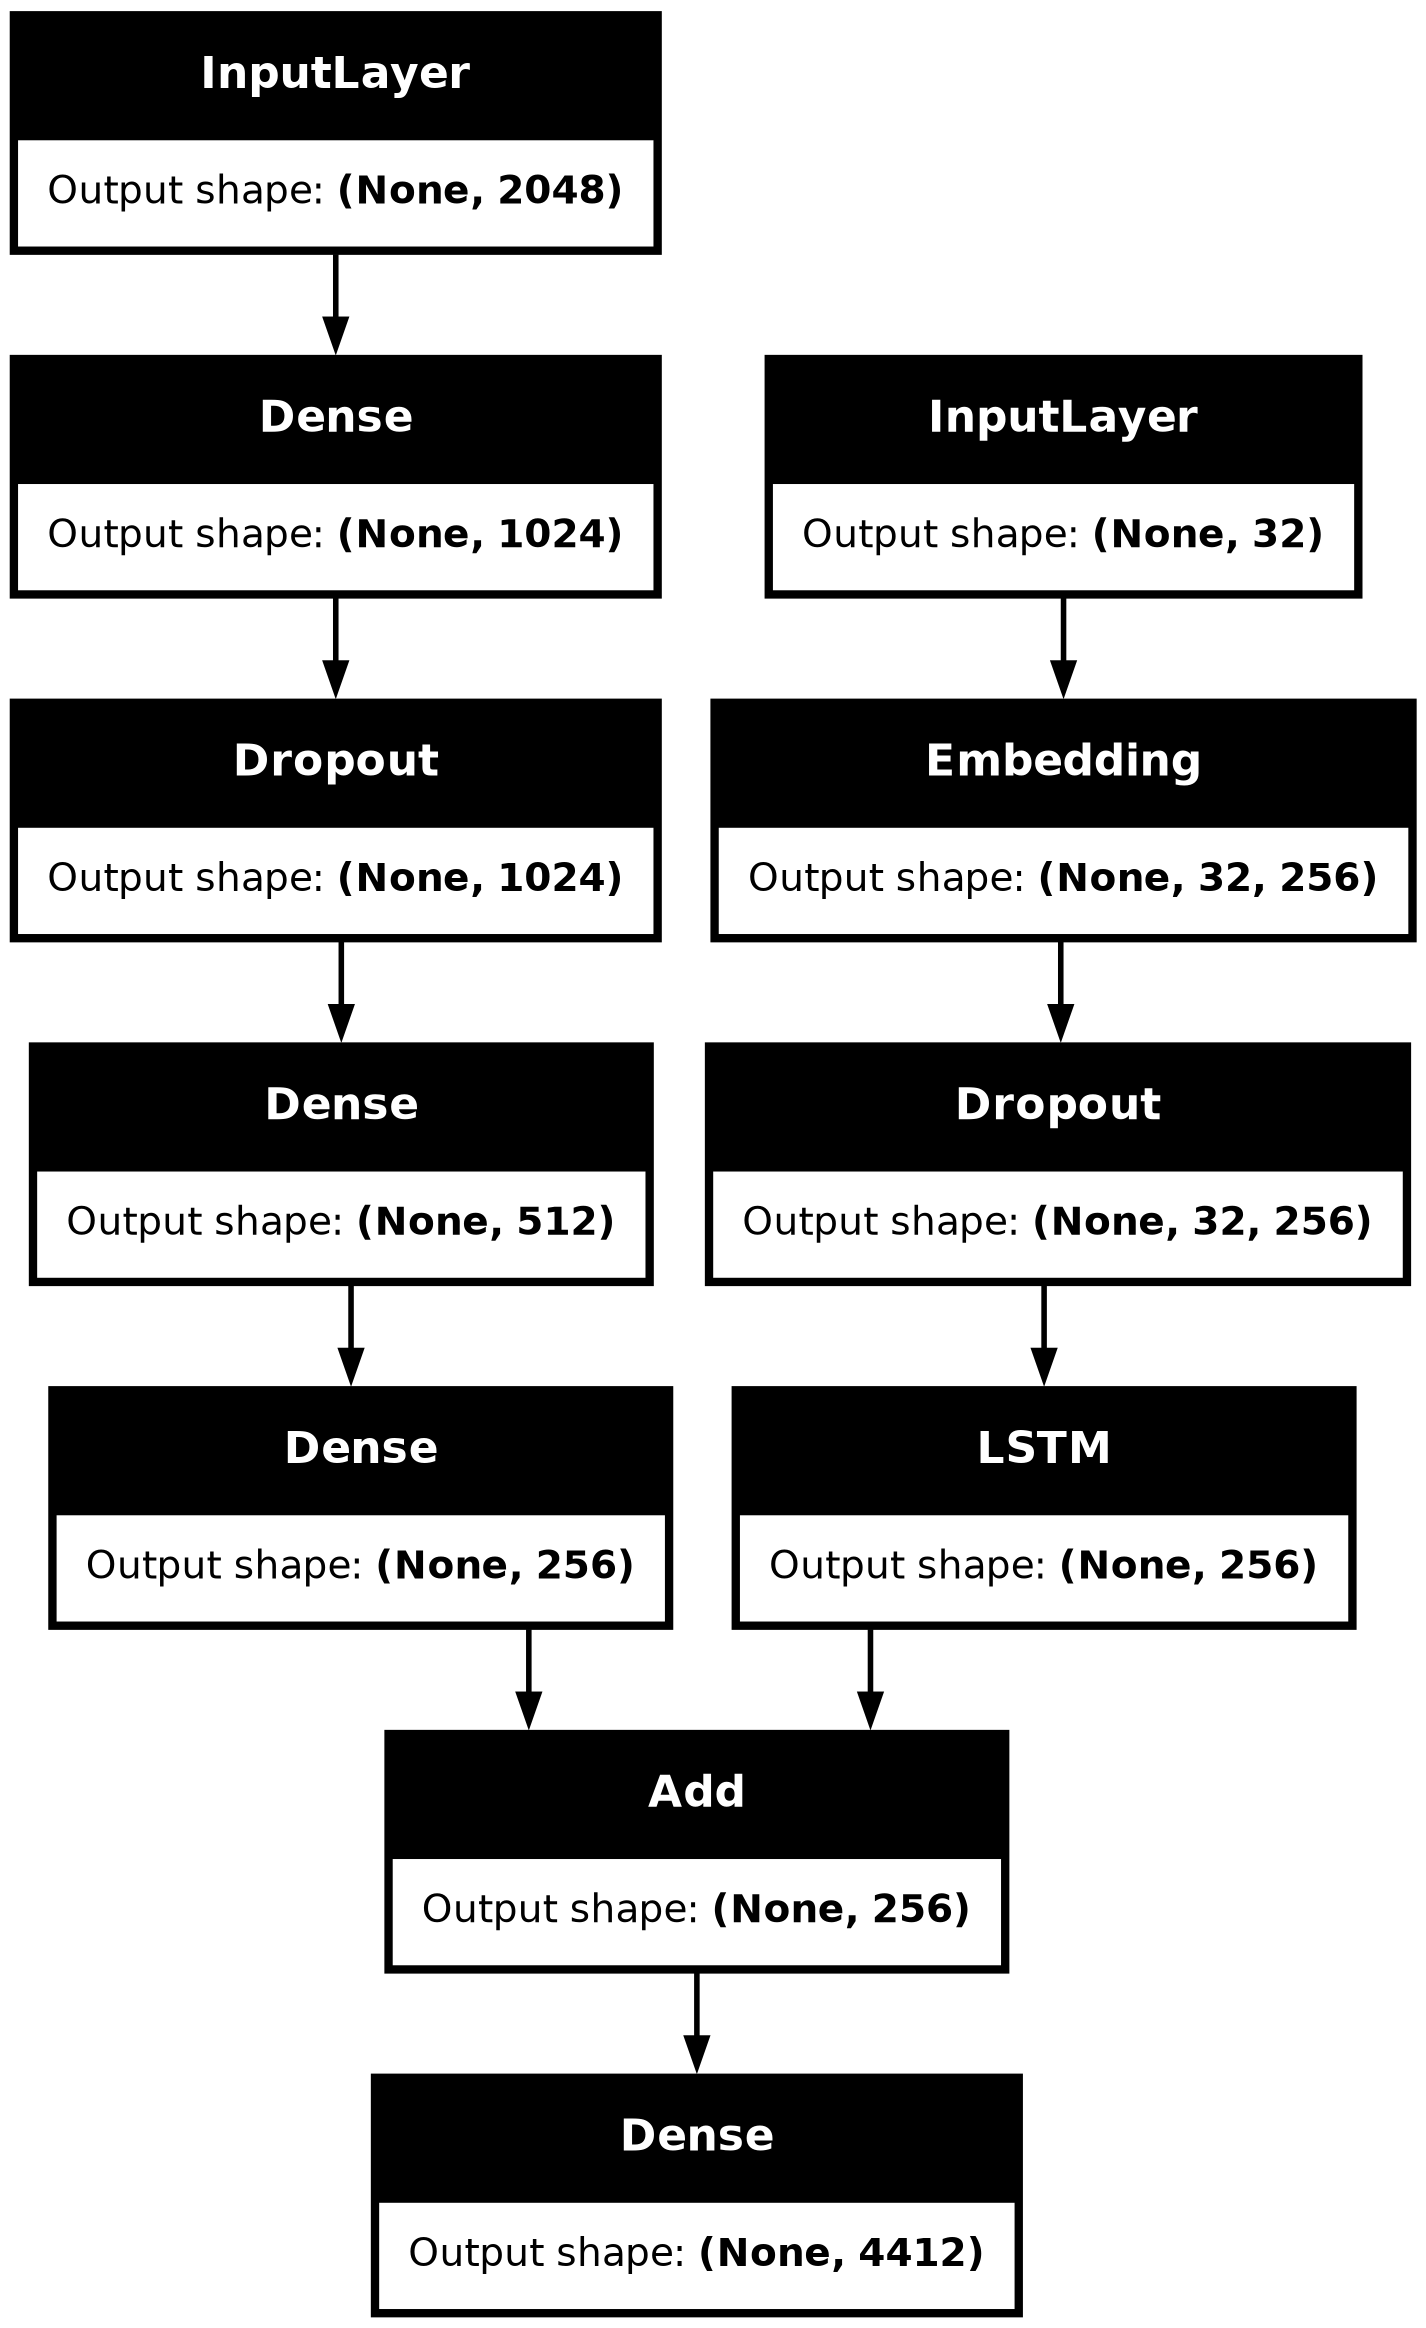

In [31]:
# plot the model
plot_model(model, show_shapes=True)

In [32]:
features, subsequences, next_output = features_and_outputs_labels(img_caption, img_feature, tokenizer, max_length, vocab_size)
model.fit((features, subsequences), next_output, epochs = 10, verbose = 1)

Epoch 1/10
  13/2604 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.0842 - loss: 7.6545  

W0000 00:00:1716196846.705838     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716196846.710526     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.1921 - loss: 5.1078
Epoch 2/10
   9/2604 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.3458 - loss: 3.4514

W0000 00:00:1716196878.821119     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716196878.825241     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2957 - loss: 3.7259
Epoch 3/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.3292 - loss: 3.2503
Epoch 4/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.3598 - loss: 2.9073
Epoch 5/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3938 - loss: 2.5986
Epoch 6/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.4368 - loss: 2.3497
Epoch 7/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.4657 - loss: 2.1567
Epoch 8/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.5070 - loss: 1.9661
Epoch 9/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.5360 - loss: 1.8272
Epoch 10/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.5662 - loss: 1.6937


In [33]:
# model = train_model(model, img_caption, img_feature, tokenizer, max_length, vocab_size, num_of_epochs = 10)

In [34]:
print(len(list(img_caption)))
print(len(list(img_feature)))

8091
8091


In [35]:
# save the model
model.save(WORKING_DIR + '/lstm.h5')

In [36]:
# validate with validation data
actual, predicted = list(), list()

for key in tqdm(validation_ids[:10]):
    # get actual caption
    caption = img_caption[key]
    # predict the caption for image
    y_pred = predict_caption(model, img_feature[key], tokenizer, max_length)
    # split into words
    actual_captions = caption.split()
    y_pred = y_pred.split()
    # append to the list
    actual.append([actual_captions])
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/10 [00:00<?, ?it/s]

BLEU-1: 0.387524
BLEU-2: 0.216691


In [37]:
# Testing on a subset of testing data for some visualizations
actual, predicted = list(), list()

for key in tqdm(test_ids[:10]):
    # get actual caption
    caption = img_caption[key]
    print('Actual: ', caption)
    # predict the caption for image
    y_pred = predict_caption(model, img_feature[key], tokenizer, max_length)
    print('Predicted: ', y_pred)
    # split into words
    actual_captions = caption.split()
    y_pred = y_pred.split()
    # append to the list
    actual.append([actual_captions])
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/10 [00:00<?, ?it/s]

Actual:  startseq boy in black clothes is doing cartwheel on the beach endseq
Predicted:  startseq girl in white shirt is standing on the beach with her flying everywhere endseq
Actual:  startseq boys with bottles pose in shopping carts in urban area endseq
Predicted:  startseq man in red shirt is walking past green wheelbarrow endseq
Actual:  startseq child in white shirt clapping their hands endseq
Predicted:  startseq group of people are standing in the middle of field of some bushes endseq
Actual:  startseq girl in colorful clothes on the beach endseq
Predicted:  startseq girl in pink jacket is standing in the middle of some trees endseq
Actual:  startseq child throws something for white dog to catch endseq
Predicted:  startseq boy holds goat in his mouth endseq
Actual:  startseq breakdancer is standing on one hand with look of excitement endseq
Predicted:  startseq man in black shirt is sitting on wall examining wooden bear endseq
Actual:  startseq crowd of people wearing red shir

In [38]:
# Full testing
actual, predicted = list(), list()

for key in tqdm(test_ids):
    # get actual caption
    caption = img_caption[key]
    # predict the caption for image
    y_pred = predict_caption(model, img_feature[key], tokenizer, max_length)
    # split into words
    actual_captions = caption.split()
    y_pred = y_pred.split()
    # append to the list
    actual.append([actual_captions])
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.355548
BLEU-2: 0.177093


# **Step 5: Caption Generation**

In [39]:
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name + '.jpg')
    image = Image.open(img_path)
    caption = img_caption[image_id]
    print('Actual caption: ')
    print(caption)
    # predict the caption
    y_pred = predict_caption(model, img_feature[image_id], tokenizer, max_length)
    print('Predicted caption: ')
    print(y_pred)
    plt.imshow(image)

# Showcasing some examples from testing

Actual caption: 
startseq black dog in water endseq
Predicted caption: 
startseq black dog is walking along the beach endseq


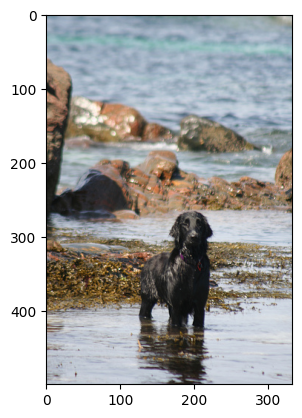

In [40]:
# Good prediction
generate_caption(test_ids[9]);

Actual caption: 
startseq crowd of people wearing red shirts runs along city road endseq
Predicted caption: 
startseq crowd of people are standing in the middle of field of some bushes endseq


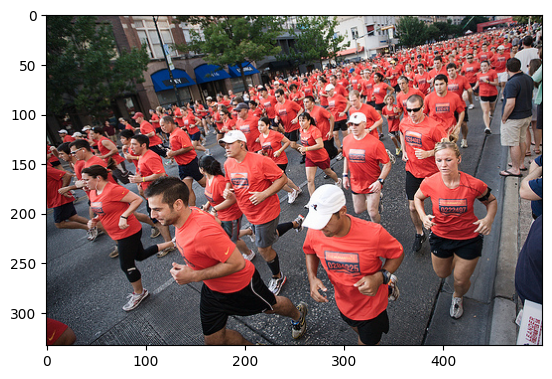

In [41]:
# Moderate prediction
generate_caption(test_ids[6]);

Actual caption: 
startseq two females are standing next to each other and appear to be unexcited endseq
Predicted caption: 
startseq girl in pink shirt is looking down at an older lady 's book endseq


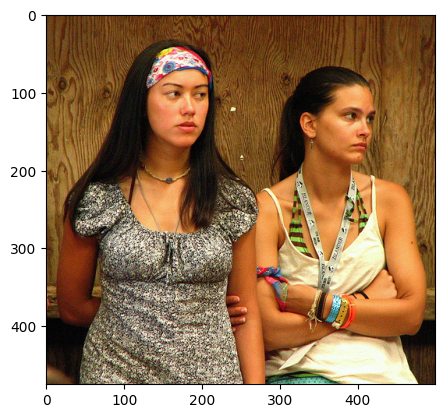

In [42]:
# Somewhat bad prediction
generate_caption(test_ids[8]);

Actual caption: 
startseq child throws something for white dog to catch endseq
Predicted caption: 
startseq boy holds goat in his mouth endseq


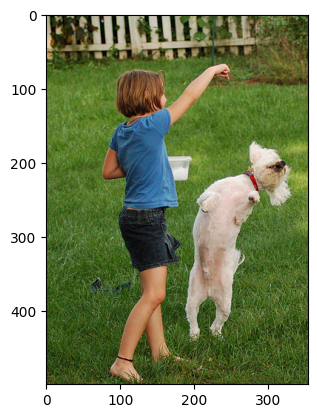

In [43]:
# Bad prediction
generate_caption(test_ids[4]);

# Testing an image from the internet

In [59]:
import requests

def download_image(url, file_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, 'wb') as f:
            f.write(response.content)
        return file_path
    else:
        print(f"Failed to download image from {url}")
        return None

def process_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    if img.shape == (224, 224, 3):
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        img = img / 255.0  # Normalize the image
        return img
    else:
        print(f"Image at {image_path} has an incorrect shape: {img.shape}")
        return None

def predict_caption(model, feature, tokenizer, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

None
(1, 224, 224, 3)


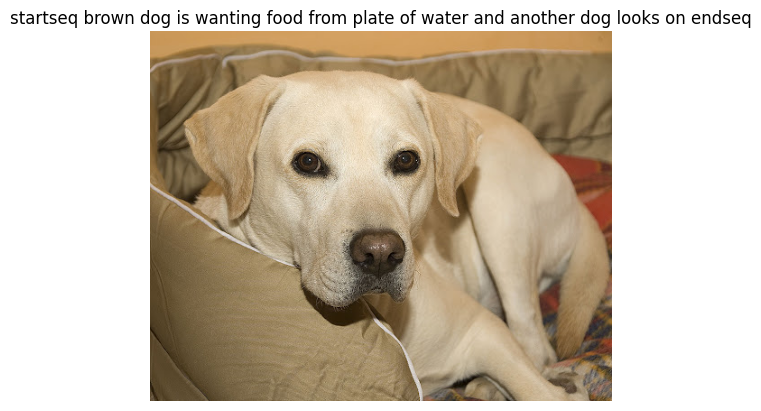

In [66]:
# List of image URLs for testing
image_urls = [
    "https://lh5.googleusercontent.com/proxy/dMd9ayKz6DTzWEZMGDzZymfAgIydS1xLxn9DiQcS-VyGCq9enI07KtlGaUdZEp99fjLP34QHSHb_bm6W8w",
]
resNet_model = generate_resNet_model()
# Directory to save downloaded images
os.makedirs("downloaded_images", exist_ok=True)
# extract features from image
features = {}
directory = '/kaggle/working/downloaded_images/image_1.jpg'
# load the image from file
img_path = directory
image = load_img(img_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
print(image.shape)
# extract features
downloaded_feature = resNet_model.predict(image, verbose=0)

caption = predict_caption(model, downloaded_feature, tokenizer, max_length)

# Display the image and the caption
plt.imshow(Image.open(file_path))
plt.title(caption)
plt.axis('off')
plt.show()


# **Step 6: Hyperparameter Tuning**

# Tuning the number of epochs

In [46]:
# history = model.fit((features, subsequences), next_output, epochs=35, verbose=1)

In [47]:
# # Plot training loss values
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train'], loc='upper left')

# # Plot training accuracy values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train'], loc='upper left')

# plt.show()

In [48]:
model_2 = generate_model(max_length, vocab_size, 256, 0.2)

In [49]:
history_2 = model_2.fit((features, subsequences), next_output, epochs=25, verbose=1)

Epoch 1/25
  13/2604 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.0415 - loss: 7.8527  

W0000 00:00:1716197796.365136     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716197796.369838     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.1900 - loss: 5.1353
Epoch 2/25
   9/2604 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.3135 - loss: 3.5788

W0000 00:00:1716197828.598801     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716197828.602955     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2942 - loss: 3.7460
Epoch 3/25
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.3265 - loss: 3.2850
Epoch 4/25
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3545 - loss: 2.9496
Epoch 5/25
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3887 - loss: 2.6513
Epoch 6/25
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.4230 - loss: 2.4158
Epoch 7/25
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.4606 - loss: 2.2052
Epoch 8/25
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.4948 - loss: 2.0280
Epoch 9/25
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.5222 - loss: 1.8906
Epoch 10/25
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.5496 - loss: 1.7588
Epoch 11/25
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.5760 - loss: 1.6490
Epoch 12/25
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.5990 - loss: 1.5429
Epoch 13/25
2604/2

In [ ]:
loss, accuracy = model_2.evaluate((test_features, test_subsequences), test_next_output, verbose=1)

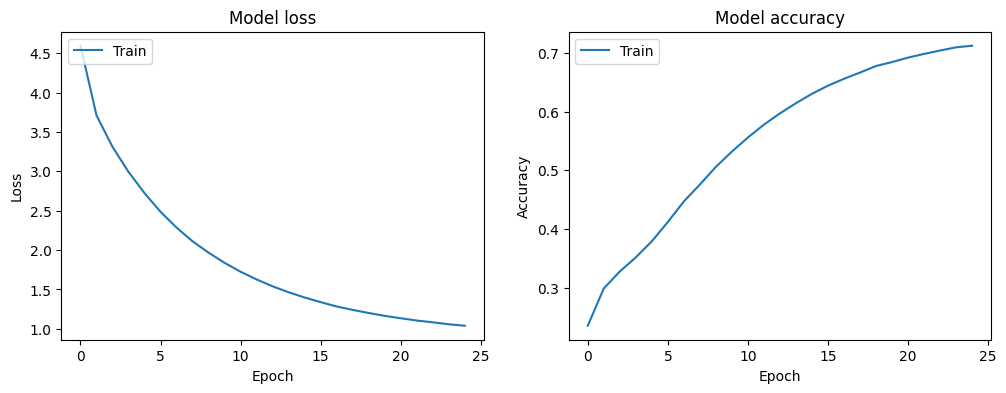

In [50]:
# Plot training loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.show()

Epoch 1/5
  21/2604 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.0109 - loss: 8.0728     

W0000 00:00:1716198928.422249     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.1333 - loss: 5.6842
Epoch 2/5


W0000 00:00:1716198947.135109     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716198947.136025     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.2171 - loss: 4.6139
Epoch 3/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.2588 - loss: 4.1847
Epoch 4/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.2749 - loss: 3.9517
Epoch 5/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.2864 - loss: 3.7916
Epoch 1/5
  19/2604 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.0425 - loss: 7.9683     

W0000 00:00:1716199038.550825     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.1497 - loss: 5.5279
Epoch 2/5
  13/2604 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.2013 - loss: 4.3538 

W0000 00:00:1716199057.215294     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2492 - loss: 4.2747
Epoch 3/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2805 - loss: 3.8632
Epoch 4/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.2963 - loss: 3.6161
Epoch 5/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.3127 - loss: 3.4321
Epoch 1/5
  16/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.0606 - loss: 7.8456  

W0000 00:00:1716199126.458923     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199126.461755     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.1741 - loss: 5.2930
Epoch 2/5
  16/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2697 - loss: 4.1769

W0000 00:00:1716199148.501350     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2770 - loss: 3.9600
Epoch 3/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.3048 - loss: 3.5459
Epoch 4/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.3285 - loss: 3.2558
Epoch 5/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.3464 - loss: 3.0341
Epoch 1/5
  13/2604 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.0438 - loss: 7.8662  

W0000 00:00:1716199230.966216     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199230.970929     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.1943 - loss: 5.1050
Epoch 2/5
   9/2604 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.2536 - loss: 4.2610

W0000 00:00:1716199262.028623     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199262.032715     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.2995 - loss: 3.7321
Epoch 3/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3295 - loss: 3.2759
Epoch 4/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3593 - loss: 2.9363
Epoch 5/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3919 - loss: 2.6388


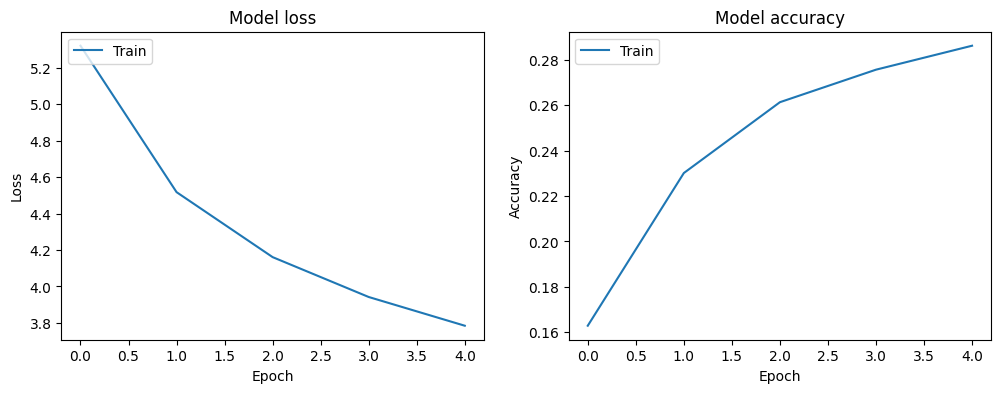

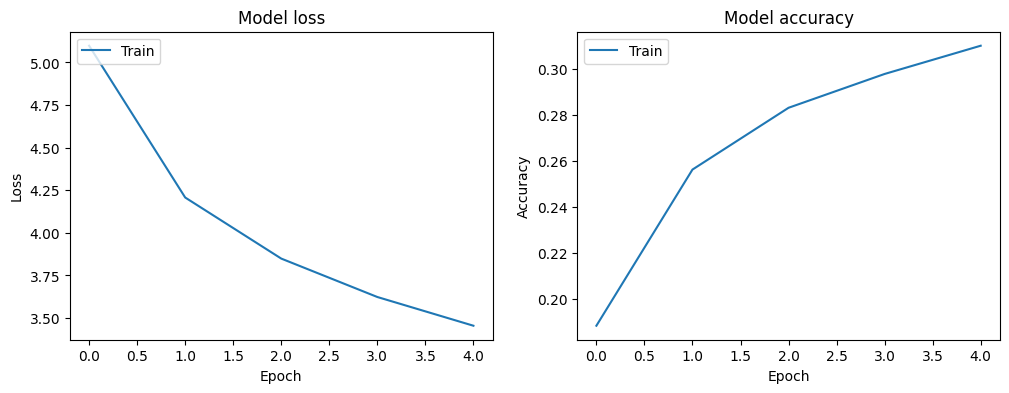

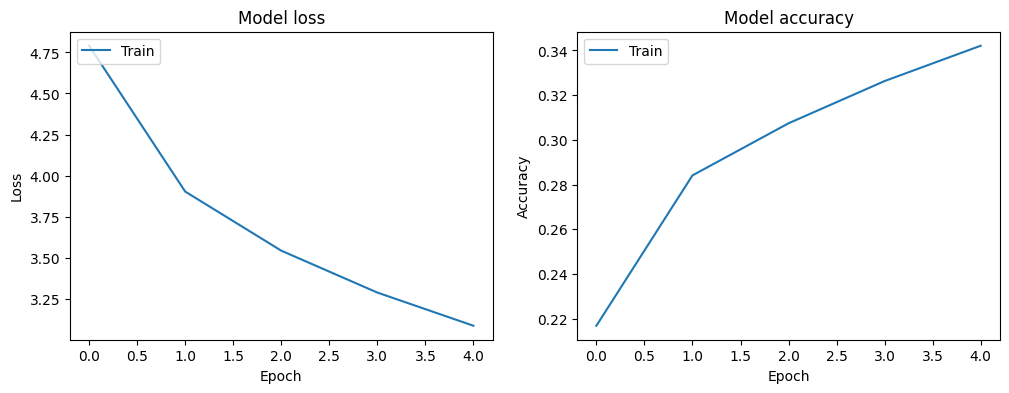

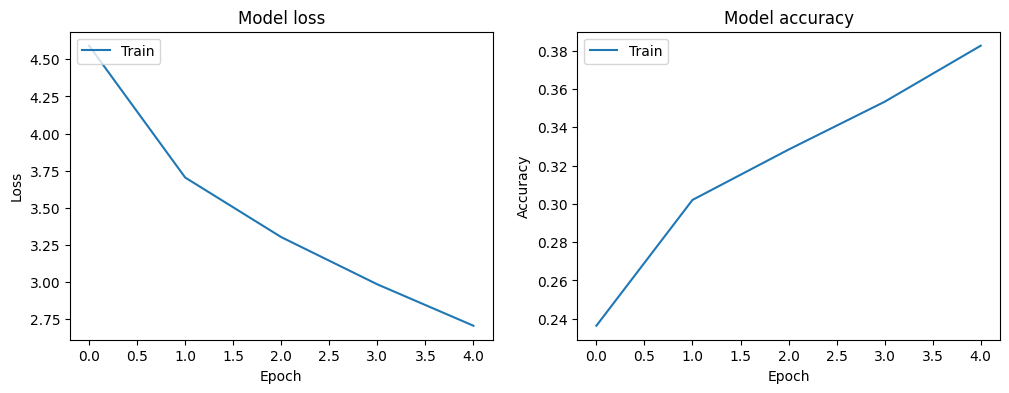

In [57]:
dropouts = [0, 0.2, 0.5]
embeddings = [32, 64, 128, 256]
histories = []
for embedding in embeddings:
    dropout = 0.2
    temp_model = generate_model(max_length, vocab_size, embedding, dropout)
    temp_history = temp_model.fit((features, subsequences), next_output, epochs=5, verbose=1)
    histories.append(temp_history)

for history in histories:
    # Plot training loss values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    # Plot training accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    plt.show()

Epoch 1/5
  13/2604 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.0522 - loss: 7.9849  

W0000 00:00:1716199494.109091     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199494.113773     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.1929 - loss: 5.1058
Epoch 2/5
   9/2604 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.3848 - loss: 3.5748

W0000 00:00:1716199523.989224     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199523.993342     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3035 - loss: 3.6577
Epoch 3/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.3370 - loss: 3.1981
Epoch 4/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3682 - loss: 2.8155
Epoch 5/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.4092 - loss: 2.4944
Epoch 1/5
   9/2604 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.0421 - loss: 8.0041    

W0000 00:00:1716199641.764532     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199641.769262     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.1933 - loss: 5.1235
Epoch 2/5
   9/2604 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.2728 - loss: 3.8946

W0000 00:00:1716199673.143548     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199673.147674     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.2949 - loss: 3.7254
Epoch 3/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3259 - loss: 3.2951
Epoch 4/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.3569 - loss: 2.9386
Epoch 5/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3930 - loss: 2.6271
Epoch 1/5
  13/2604 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.0546 - loss: 7.9687  

W0000 00:00:1716199791.743327     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199791.747835     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.1828 - loss: 5.1989
Epoch 2/5
   9/2604 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.3124 - loss: 3.6903

W0000 00:00:1716199823.081155     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199823.085128     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.2870 - loss: 3.8563
Epoch 3/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3132 - loss: 3.4221
Epoch 4/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.3357 - loss: 3.1208
Epoch 5/5
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3620 - loss: 2.8610


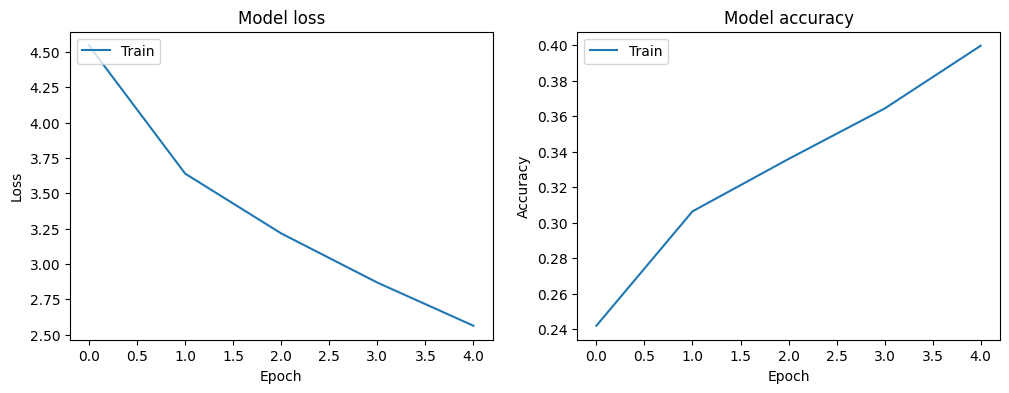

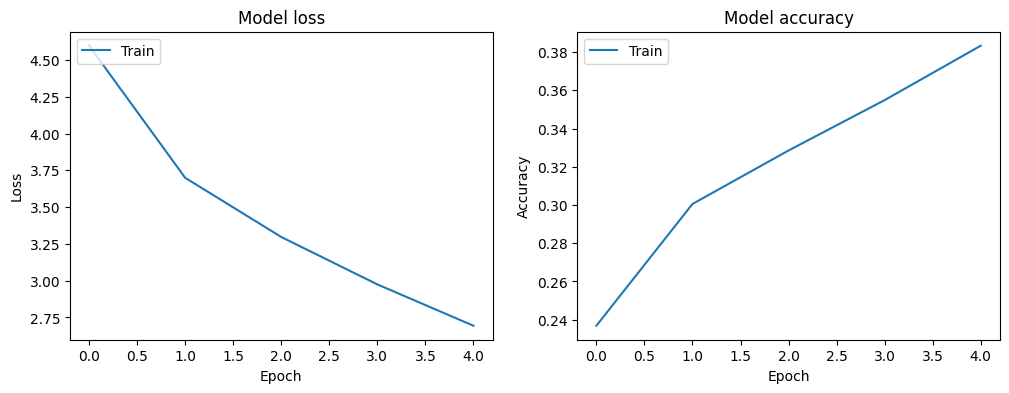

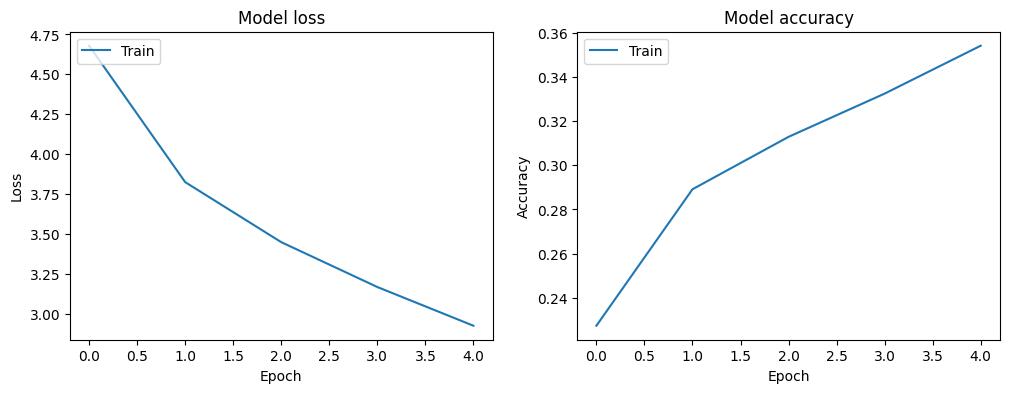

In [58]:
histories = []
for dropout in dropouts:
    emb = 256
    temp_model = generate_model(max_length, vocab_size, emb, dropout)
    temp_history = temp_model.fit((features, subsequences), next_output, epochs=5, verbose=1)
    histories.append(temp_history)

for history in histories:
    # Plot training loss values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    # Plot training accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    plt.show()

In [51]:
# # Validate with test data
# actual, predicted = list(), list()

# for img_id in tqdm(test_ids[:10], desc="Processing"):
#     actual_caption = img_caption[img_id]
#     print(f"Actual : {actual_caption}")
#     # Tokenize and preprocess actual caption
#     actual_caption = actual_caption.lower()
#     actual_caption = re.sub(r"[^\w\s]", "", actual_caption)
#     actual_caption = actual_caption.split()
#     actual_caption = [word for word in actual_caption if word not in ('startseq', 'endseq')]
    
#     # Predict the caption for the image
#     pred_caption = predict_caption(model, img_feature[img_id], tokenizer, max_length)
#     print(f"Predicted : {pred_caption} \n")
#     # Tokenize and preprocess predicted caption
#     pred_caption = pred_caption.lower()
#     pred_caption = re.sub(r"[^\w\s]", "", pred_caption)
#     pred_caption = pred_caption.split()
#     pred_caption = [word for word in pred_caption if word not in ('startseq', 'endseq')]
    
#     actual.append([actual_caption])  # wrap in another list to match corpus_bleu's expected input
#     predicted.append(pred_caption)

# # Calculate BLEU scores
# print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
# print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
# print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
